<a href="https://colab.research.google.com/github/mjrakmad/MDS210_BigDataProject/blob/main/BIG_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Air Quality Data in Cotabato City Using Spark**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **LIBRARIES**

In [5]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [6]:
sparkSession = SparkSession.builder.appName('bigdata').getOrCreate()

In [7]:
df_pyspark = sparkSession.read.csv('/content/drive/MyDrive/Dataset/CotabatoCity_AQMS.csv',
    header=True,
    inferSchema=True
)

## **DATA CLEANING**

In [8]:

# Print Schema
df_pyspark.printSchema()

# Print Dataframe
df_pyspark.show()

root
 |-- Date and Time: string (nullable = true)
 |-- Wind Speed: double (nullable = true)
 |-- Wind Direction: double (nullable = true)
 |-- Barometric Pressure: double (nullable = true)
 |-- Ambient Humidity: double (nullable = true)
 |-- Ambient Temperature: double (nullable = true)
 |-- Solar Radiation: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- PM10 Concentration: double (nullable = true)
 |-- PM25 Concentration: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOX: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- O3: double (nullable = true)
 |-- PM10 AQI: integer (nullable = true)
 |-- PM25 AQI: integer (nullable = true)
 |-- NO2 Index: integer (nullable = true)
 |-- SO2 Index: integer (nullable = true)
 |-- CO Index: string (nullable = true)
 |-- O3 Index: string (nullable = true)
 |-- AQI Index: integer (nullable = true)

+----------------+----------+

In [9]:
from pyspark.sql.functions import col, isnan, when, count

# Count missing values (null or NaN) for each column in df_pyspark
missing_values = df_pyspark.select(
    [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_pyspark.columns]
)

missing_values.show()

+-------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+---+----+---+---+--------+--------+---------+---------+--------+--------+---------+
|Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2|NOX| SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|SO2 Index|CO Index|O3 Index|AQI Index|
+-------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+---+----+---+---+--------+--------+---------+---------+--------+--------+---------+
|            0|         0|             0|                  0|               0|                  0|              0|       0|                 0|                 0|  0|  0|  0|2250|  0|  0|       0|       0|        0|     2250|       0|       0

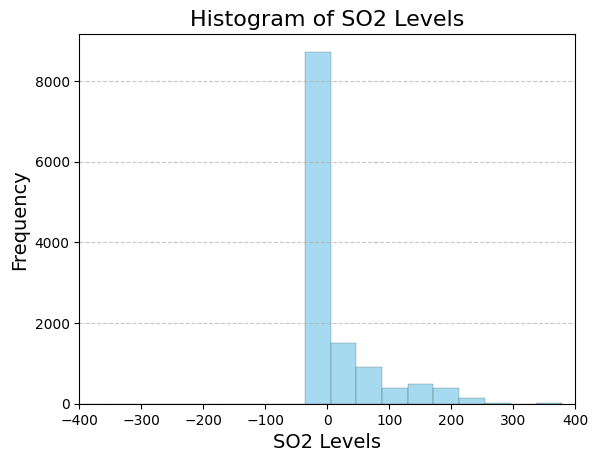

In [10]:


# Step 1: Select SO2 column and convert it to Pandas for visualization
so2_data = df_pyspark.select("SO2").dropna().toPandas()

# Step 2: Plot the histogram
sns.histplot(so2_data["SO2"], bins=250, kde=False, color="skyblue")

# Step 3: Customize the plot
plt.xlim(-400, 400)  # Set x-axis limits
plt.title("Histogram of SO2 Levels", fontsize=16)
plt.xlabel("SO2 Levels", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

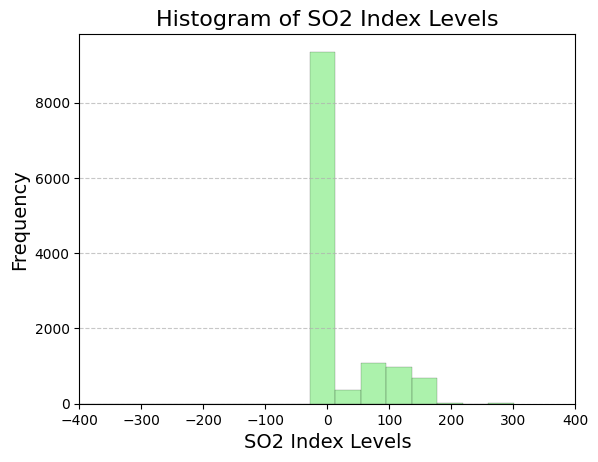

In [11]:
# Step 1: Select SO2 column and convert it to Pandas for visualization
so2_data = df_pyspark.select("SO2 Index").dropna().toPandas()

# Step 2: Plot the histogram
sns.histplot(so2_data["SO2 Index"], bins=250, kde=False, color="lightgreen")

# Step 3: Customize the plot
plt.xlim(-400, 400)  # Set x-axis limits
plt.title("Histogram of SO2 Index Levels", fontsize=16)
plt.xlabel("SO2 Index Levels", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
so2_median = df_pyspark.approxQuantile("SO2", [0.5], 0.0)[0]  # Median for SO2

so2_index_median = df_pyspark.approxQuantile("SO2 Index", [0.5], 0.0)[0]  # Median for SO2 Index

# Step 3: Impute missing values for both SO2 and SO2 Index
df_pyspark_imputed = df_pyspark.fillna({"SO2": so2_median, "SO2 Index": so2_index_median})

# Step 4: Show the resulting DataFrame
df_pyspark_imputed.show()

+----------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+---+---+---+--------+--------+---------+---------+--------+--------+---------+
|   Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2| NOX|SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|SO2 Index|CO Index|O3 Index|AQI Index|
+----------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+---+---+---+--------+--------+---------+---------+--------+--------+---------+
|06/11/2024 15:00|       2.4|         292.2|             1016.8|            52.5|             -244.7|           12.2|     0.0|              14.4|               4.3|1.6|7.7| 9.2|0.6|0.0|0.0|      13|      18|        7|        1|     

Text(0, 0.5, 'Frequency')

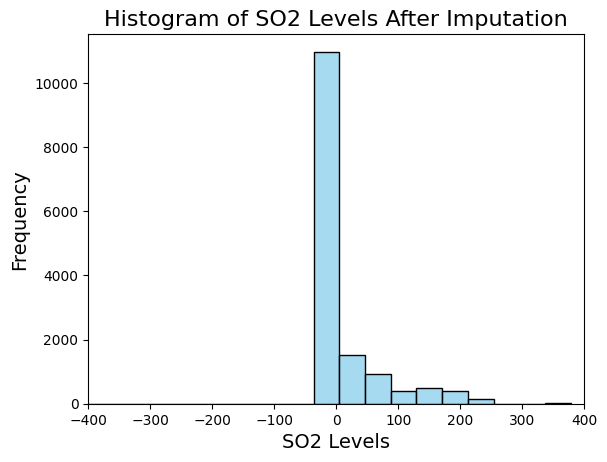

In [13]:
imputed_data = df_pyspark_imputed.select("SO2", "SO2 Index").toPandas()

# Plot histogram for SO2
plt.xlim(-400, 400)  # Set x-axis limits
sns.histplot(imputed_data["SO2"], bins=250, kde=False, color="skyblue")
plt.title("Histogram of SO2 Levels After Imputation", fontsize=16)
plt.xlabel("SO2 Levels", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

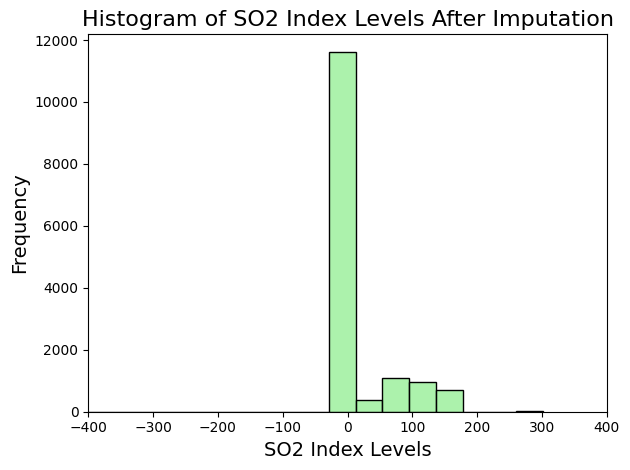

In [14]:
# Plot histogram for SO2 Index
plt.xlim(-400, 400)  # Set x-axis limits
sns.histplot(imputed_data["SO2 Index"], bins=250, kde=False, color="lightgreen")
plt.title("Histogram of SO2 Index Levels After Imputation", fontsize=16)
plt.xlabel("SO2 Index Levels", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## **FEATURE EXTRACTION**

In [15]:
#New Features
# extract month, day and time

from pyspark.sql.functions import date_format, to_timestamp

# Step 1: Convert "Date and Time" column to TimestampType if not already
df_pyspark = df_pyspark_imputed.withColumn("Date and Time", to_timestamp("Date and Time", "dd/MM/yyyy HH:mm"))

# Step 2: Extract the day
df_pyspark = df_pyspark.withColumn("Day", date_format("Date and Time", "dd"))

# Step 3: Extract the hour
df_pyspark = df_pyspark.withColumn("Hour", date_format("Date and Time", "HH"))

# Step 4: Extract the month
df_pyspark = df_pyspark.withColumn("Month", date_format("Date and Time", "MM"))

# Show the updated DataFrame
df_pyspark.show()

+-------------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+---+---+---+--------+--------+---------+---------+--------+--------+---------+---+----+-----+
|      Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2| NOX|SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|SO2 Index|CO Index|O3 Index|AQI Index|Day|Hour|Month|
+-------------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+---+---+---+--------+--------+---------+---------+--------+--------+---------+---+----+-----+
|2024-11-06 15:00:00|       2.4|         292.2|             1016.8|            52.5|             -244.7|           12.2|     0.0|              14.4|               4.3|1.6|7.7| 9.

In [16]:
from pyspark.sql.functions import when

def categorize_aqi(aqi_value):
  # Use when and otherwise for conditional logic within the PySpark DataFrame context
  return when(aqi_value <= 50, "Good").\
         when(aqi_value <= 100, "Moderate").\
         when(aqi_value <= 150, "Unhealthy for Sensitive Groups").\
         when(aqi_value <= 200, "Unhealthy").\
         when(aqi_value <= 300, "Very Unhealthy").\
         otherwise("Hazardous")

# Apply the categorize_aqi function to the 'SO2 Index' column
df_pyspark = df_pyspark.withColumn("AQI_Category", categorize_aqi(col("SO2 Index")))

df_pyspark.show()

+-------------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+---+---+---+--------+--------+---------+---------+--------+--------+---------+---+----+-----+------------+
|      Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2| NOX|SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|SO2 Index|CO Index|O3 Index|AQI Index|Day|Hour|Month|AQI_Category|
+-------------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+---+---+---+--------+--------+---------+---------+--------+--------+---------+---+----+-----+------------+
|2024-11-06 15:00:00|       2.4|         292.2|             1016.8|            52.5|             -244.7|           12.2|     0.0|          

## **Visualization**

+-------------------+----------+--------------+-------------------+----------------+-------------------+---------------+--------+------------------+------------------+---+---+----+---+---+---+--------+--------+---------+---------+--------+--------+---------+---+----+-----+------------+------------------+--------------------+------------------+-------------------+-----------------+-------------------+------------------+--------------------+-------------------+--------------------+------------------+
|      Date and Time|Wind Speed|Wind Direction|Barometric Pressure|Ambient Humidity|Ambient Temperature|Solar Radiation|Rainfall|PM10 Concentration|PM25 Concentration| NO|NO2| NOX|SO2| CO| O3|PM10 AQI|PM25 AQI|NO2 Index|SO2 Index|CO Index|O3 Index|AQI Index|Day|Hour|Month|AQI_Category|    SO2_normalized|SO2 Index_normalized|     CO_Normalized|CO Index_Normalized|    O3_Normalized|O3 Index_Normalized|    NO2_Normalized|NO2 Index_Normalized|     Day_normalized|     Hour_normalized|  Month_norm

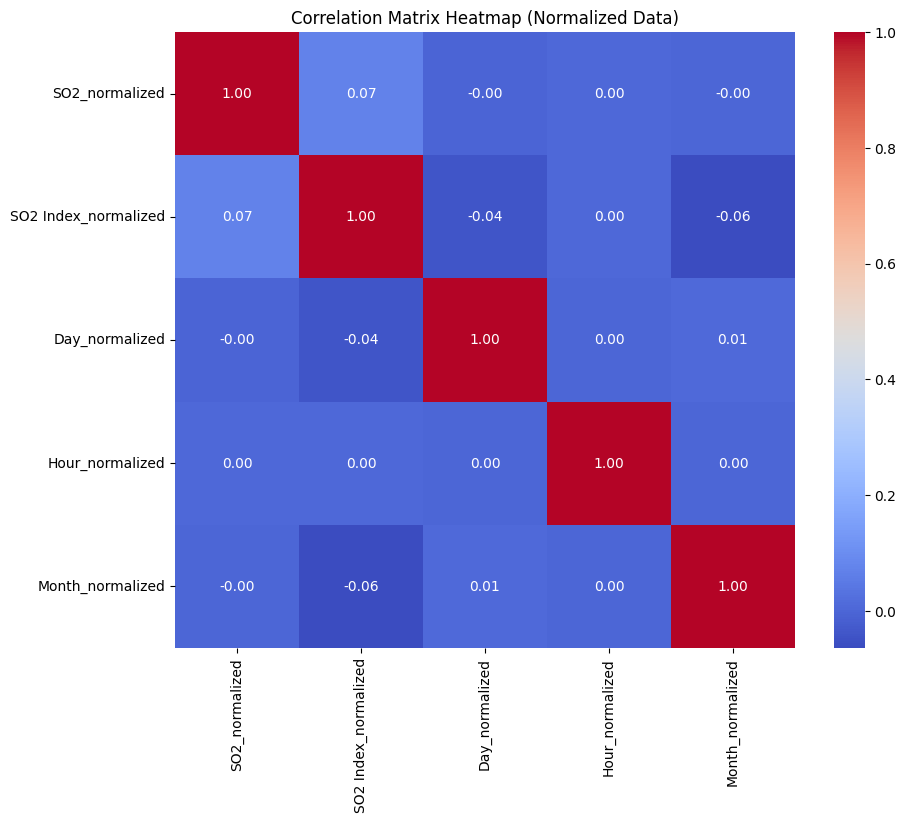